In [1]:
from pandas_datareader import data
import matplotlib.pyplot as plt
import yfinance as yf
import statsmodels.api as sm
import statsmodels.formula.api as smf 
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
import pyarrow.parquet as pq
import pickle
import numpy as np
import time
import seaborn as sns
from itertools import combinations
import multiprocessing as mp
from tqdm import tqdm
import sys
import pandas as pd
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)

In [3]:
table2 = pq.read_table('E:\\Downloads\\stats-econ-homework\\obs_data.parquet')
base=table2.to_pandas()

In [4]:
base.head()

,id,date,collections_start,days_late,bureau_1,bureau_2,late_payments,collection__end,std_revolving_balance_30,agreement_amount_mean,oustanting_balance_weight_30,oustanting_balance_weight_90,max_installments_balance_90,max_payment_90,sum_limit_request_time_weight_180,loss_balance,avg_late_balance_0_180,email_event_30,count_inbound_call_inbound_30,avg_call_duration_30,avg_installments_balance_30,charges_agreement_mean,ongoing_agreement_amount,asset_late_balance,ongoing_agreement_downpayment,recovery_balance,std_installments_balance_0_90,last_email_engagement,last_chat_engagement,finantial_institutions,downpayment_mean,avg_spends,score_1,score_2,score_3,income_score_1,count_previous_delinquencies,income_score_2,age,mean_previous_delinquencies_amount_weight_180,mean_previous_delinquencies_duration_90,score_max_credit_limit,credit_limit_utilization,sum_spends_360
0,94b47b2c-24ca-4c0b-8a1b-d47b8c6094ce,2017-01-01,2017-01-01,0,0,0,0,2017-02-13,0.0,NaN,69.0,16.0,0.0,540.0,2.0,19.0,23.0,1.0,1.0,0.0,0.0,NaN,NaN,20.0,NaN,2.0,0.0,NaN,16.0,1.0,NaN,NaN,635.0,22.0,30.0,2221.0,3.0,1624.0,39.0,19.0,6.0,1128.0,1.0,196.0
1,ee254bce-3eec-46cd-a440-826631a44783,2017-01-01,2017-01-01,0,0,0,40,2017-06-14,0.0,NaN,55.0,1.0,0.0,18.0,1.0,33.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,162.0,NaN,4.0,NaN,NaN,342.0,214.0,323.0,1012.0,1.0,15828.0,45.0,3.0,0.0,2111.0,1.0,18.0
2,74a49cd6-44f8-41cc-926b-b324794f6837,2017-01-01,2017-01-01,0,0,0,0,2017-02-03,3.0,NaN,1635.0,15.0,0.0,58.0,0.0,111.0,93.0,0.0,0.0,2.0,1.0,NaN,NaN,71.0,NaN,0.0,0.0,NaN,NaN,5.0,NaN,38.0,149.0,104.0,149.0,3958.0,5.0,7801.0,48.0,19.0,3.0,835.0,1.0,0.0
3,e4552188-6002-44f4-b539-1043cf1dd057,2017-01-01,2017-01-01,0,0,0,0,2017-03-01,9.0,NaN,2.0,9.0,0.0,0.0,1.0,0.0,233.0,1.0,1.0,8.0,3.0,NaN,NaN,54.0,NaN,0.0,0.0,54.0,NaN,1.0,NaN,NaN,389.0,58.0,119.0,1624.0,4.0,3786.0,40.0,142.0,17.0,2148.0,1.0,43.0
4,d3005d9c-2d58-4986-9007-67a6758dd7ef,2017-01-01,2017-01-01,0,0,0,0,2017-02-15,1.0,NaN,24.0,3.0,0.0,33240.0,2.0,42.0,1.0,1.0,1.0,2.0,0.0,NaN,NaN,7.0,NaN,1.0,0.0,NaN,19.0,2.0,NaN,NaN,787.0,98.0,134.0,900.0,1.0,4691.0,35.0,1.0,6.0,2690.0,1.0,10.0


In [5]:
base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53939 entries, 0 to 53938
Data columns (total 44 columns):
id                                               53939 non-null object
date                                             53939 non-null datetime64[ns]
collections_start                                53939 non-null datetime64[ns]
days_late                                        53939 non-null int64
bureau_1                                         53939 non-null int64
bureau_2                                         53939 non-null int64
late_payments                                    53939 non-null int64
collection__end                                  32062 non-null datetime64[ns]
std_revolving_balance_30                         53939 non-null float64
agreement_amount_mean                            8615 non-null float64
oustanting_balance_weight_30                     53939 non-null float64
oustanting_balance_weight_90                     53939 non-null float64
max_installments

In [6]:
base.describe()

,days_late,bureau_1,bureau_2,late_payments,std_revolving_balance_30,agreement_amount_mean,oustanting_balance_weight_30,oustanting_balance_weight_90,max_installments_balance_90,max_payment_90,sum_limit_request_time_weight_180,loss_balance,avg_late_balance_0_180,email_event_30,count_inbound_call_inbound_30,avg_call_duration_30,avg_installments_balance_30,charges_agreement_mean,ongoing_agreement_amount,asset_late_balance,ongoing_agreement_downpayment,recovery_balance,std_installments_balance_0_90,last_email_engagement,last_chat_engagement,finantial_institutions,downpayment_mean,avg_spends,score_1,score_2,score_3,income_score_1,count_previous_delinquencies,income_score_2,age,mean_previous_delinquencies_amount_weight_180,mean_previous_delinquencies_duration_90,score_max_credit_limit,credit_limit_utilization,sum_spends_360
count,53939.000000,53939.000000,53939.000000,53939.000000,53939.000000,8615.000000,53939.000000,53939.00000,53939.000000,53939.000000,53939.000000,53939.000000,53939.000000,53939.000000,53939.000000,53939.000000,53939.000000,8615.000000,2805.000000,53939.000000,2805.000000,53939.000000,53939.000000,29743.000000,27306.000000,53939.000000,8615.000000,18405.000000,53748.000000,53748.000000,53748.000000,53148.000000,53939.000000,53929.000000,53939.000000,53939.000000,53939.00000,53939.000000,53939.000000,53939.000000
mean,36.569328,0.008139,0.007879,11.509298,7.313094,1850.127104,278.680343,10.69117,11.636274,4160.861343,1.015740,531.582695,364.790245,0.567104,0.889412,2.242607,3.048851,7.209286,1786.373975,994.699568,295.381105,1.523109,5.993604,249.280839,146.428441,2.349228,374.941149,153.452323,569.106888,98.223041,157.192603,2007.253631,3.499564,4241.149604,41.168171,607.368323,11.30338,2252.656964,0.943232,206.534511
std,29.209864,0.089848,0.088416,21.098107,16.114278,1336.698371,1177.434203,16.77419,44.168598,6566.433172,0.250759,3882.446475,801.419988,0.495481,0.313624,2.525473,6.640371,6.087700,1312.558357,4313.561069,181.417646,1.497721,17.041722,265.343450,287.430953,2.116795,292.512281,224.118093,311.186577,109.960037,162.498358,1415.893616,2.457865,4927.987435,9.071001,2687.838813,22.12957,1938.205017,0.552118,1378.392582
min,0.000000,0.000000,0.000000,0.000000,-1.000000,261.000000,-39.000000,0.00000,0.000000,-755.000000,0.000000,-6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,273.000000,-74.000000,35.000000,0.000000,0.000000,8.000000,6.000000,0.000000,28.000000,2.000000,96.000000,2.000000,3.000000,124.000000,0.000000,118.000000,19.000000,-300.000000,0.00000,192.000000,0.000000,0.000000
25%,14.000000,0.000000,0.000000,0.000000,3.000000,993.000000,40.000000,2.00000,1.000000,877.000000,1.000000,23.000000,111.000000,0.000000,1.000000,1.000000,1.000000,3.000000,969.000000,6.000000,171.000000,1.000000,0.000000,95.000000,73.000000,1.000000,178.000000,39.000000,357.000000,33.000000,56.000000,1079.000000,2.000000,1382.000000,35.000000,65.000000,1.00000,1058.000000,1.000000,1.000000
50%,30.000000,0.000000,0.000000,0.000000,4.000000,1451.000000,91.000000,5.00000,2.000000,2195.000000,1.000000,32.000000,129.000000,1.000000,1.000000,2.000000,1.000000,5.000000,1381.000000,64.000000,239.000000,1.000000,1.000000,171.000000,100.000000,2.000000,270.000000,89.000000,494.000000,65.000000,108.000000,1627.000000,3.000000,2490.000000,40.000000,87.000000,4.00000,1732.000000,1.000000,7.000000
75%,53.000000,0.000000,0.000000,10.000000,7.000000,2294.000000,206.000000,11.00000,6.000000,4810.000000,1.000000,99.000000,334.000000,1.000000,1.000000,3.000000,3.000000,9.000000,2207.000000,323.000000,361.000000,2.000000,4.000000,298.000000,143.000000,3.000000,480.000000,188.000000,699.000000,118.000000,200.000000,2513.000000,5.000000,5249.000000,46.000000,423.000000,11.00000,2766.000000,1.000000,43.000000
max,165.000000,1.000000,1.000000,620.000000,566.000000,9471.000000,38632.000000,183.00000,1029.000000,93248.000000,4.000000,80193.000000,19486.000000,1.000000,1.000000,61.000000,117.000000,57.000000,8764.000000,66316.00000

In [7]:
base[base['bureau_1']==1].head()

,id,date,collections_start,days_late,bureau_1,bureau_2,late_payments,collection__end,std_revolving_balance_30,agreement_amount_mean,oustanting_balance_weight_30,oustanting_balance_weight_90,max_installments_balance_90,max_payment_90,sum_limit_request_time_weight_180,loss_balance,avg_late_balance_0_180,email_event_30,count_inbound_call_inbound_30,avg_call_duration_30,avg_installments_balance_30,charges_agreement_mean,ongoing_agreement_amount,asset_late_balance,ongoing_agreement_downpayment,recovery_balance,std_installments_balance_0_90,last_email_engagement,last_chat_engagement,finantial_institutions,downpayment_mean,avg_spends,score_1,score_2,score_3,income_score_1,count_previous_delinquencies,income_score_2,age,mean_previous_delinquencies_amount_weight_180,mean_previous_delinquencies_duration_90,score_max_credit_limit,credit_limit_utilization,sum_spends_360
804,ee254bce-3eec-46cd-a440-826631a44783,2017-01-16,2017-01-01,15,1,0,0,2017-06-14,0.0,NaN,127.0,2.0,0.0,18.0,1.0,33.0,28.0,1.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,1.0,0.0,NaN,65.0,4.0,NaN,176.0,342.0,214.0,323.0,1012.0,1.0,15828.0,45.0,3.0,0.0,2111.0,1.0,18.0
845,e4552188-6002-44f4-b539-1043cf1dd057,2017-01-16,2017-01-01,15,1,0,50,2017-03-01,9.0,NaN,40.0,13.0,0.0,0.0,1.0,0.0,158.0,1.0,1.0,8.0,3.0,NaN,NaN,54.0,NaN,0.0,0.0,54.0,NaN,1.0,NaN,140.0,389.0,58.0,119.0,1624.0,4.0,3786.0,40.0,142.0,17.0,2148.0,1.0,43.0
873,f84bc28e-7298-4d59-a315-5a3c1125f820,2017-01-16,2017-01-01,15,1,0,30,NaT,0.0,1587.0,32.0,12.0,4.0,29579.0,1.0,0.0,178.0,0.0,1.0,2.0,0.0,5.0,NaN,102.0,NaN,2.0,3.0,97.0,NaN,1.0,265.0,NaN,856.0,28.0,42.0,1951.0,2.0,3301.0,43.0,296.0,10.0,1562.0,2.0,140.0
880,40249e57-7de1-42fb-9201-afab1a3965a4,2017-01-16,2017-01-01,15,1,0,20,2017-02-18,2.0,NaN,17.0,51.0,0.0,0.0,2.0,0.0,2824.0,0.0,1.0,14.0,1.0,NaN,NaN,16662.0,NaN,0.0,0.0,79.0,NaN,1.0,NaN,165.0,1211.0,14.0,22.0,3253.0,1.0,951.0,38.0,7637.0,63.0,4323.0,3.0,4293.0
898,abd31cd5-ccc6-415c-9c76-124a01f6c898,2017-01-17,2017-01-02,15,1,0,0,2017-03-31,0.0,NaN,50.0,10.0,0.0,879.0,1.0,4.0,441.0,1.0,1.0,2.0,0.0,NaN,NaN,110.0,NaN,2.0,0.0,58.0,37.0,0.0,NaN,67.0,523.0,47.0,66.0,1724.0,9.0,15113.0,38.0,349.0,14.0,3026.0,1.0,46.0


In [8]:
base[base['bureau_2']==1].head()

,id,date,collections_start,days_late,bureau_1,bureau_2,late_payments,collection__end,std_revolving_balance_30,agreement_amount_mean,oustanting_balance_weight_30,oustanting_balance_weight_90,max_installments_balance_90,max_payment_90,sum_limit_request_time_weight_180,loss_balance,avg_late_balance_0_180,email_event_30,count_inbound_call_inbound_30,avg_call_duration_30,avg_installments_balance_30,charges_agreement_mean,ongoing_agreement_amount,asset_late_balance,ongoing_agreement_downpayment,recovery_balance,std_installments_balance_0_90,last_email_engagement,last_chat_engagement,finantial_institutions,downpayment_mean,avg_spends,score_1,score_2,score_3,income_score_1,count_previous_delinquencies,income_score_2,age,mean_previous_delinquencies_amount_weight_180,mean_previous_delinquencies_duration_90,score_max_credit_limit,credit_limit_utilization,sum_spends_360
1053,e4552188-6002-44f4-b539-1043cf1dd057,2017-01-18,2017-01-01,17,0,1,0,2017-03-01,9.0,NaN,40.0,13.0,0.0,0.0,1.0,0.0,158.0,1.0,1.0,8.0,3.0,NaN,NaN,54.0,NaN,0.0,0.0,NaN,NaN,1.0,NaN,140.0,389.0,58.0,119.0,1624.0,4.0,3786.0,40.0,142.0,17.0,2148.0,1.0,43.0
1068,d3005d9c-2d58-4986-9007-67a6758dd7ef,2017-01-18,2017-01-01,17,0,1,0,2017-02-15,1.0,NaN,117.0,7.0,0.0,33240.0,2.0,42.0,43.0,1.0,1.0,2.0,0.0,NaN,NaN,7.0,NaN,1.0,0.0,149.0,30.0,2.0,NaN,NaN,787.0,98.0,134.0,900.0,1.0,4691.0,35.0,1.0,6.0,2690.0,1.0,10.0
1090,40249e57-7de1-42fb-9201-afab1a3965a4,2017-01-18,2017-01-01,17,0,1,0,2017-02-18,2.0,NaN,17.0,51.0,0.0,0.0,2.0,0.0,2824.0,0.0,1.0,14.0,1.0,NaN,NaN,16662.0,NaN,0.0,0.0,NaN,31.0,1.0,NaN,165.0,1211.0,14.0,22.0,3253.0,1.0,951.0,38.0,7637.0,63.0,4323.0,3.0,4293.0
1107,abd31cd5-ccc6-415c-9c76-124a01f6c898,2017-01-19,2017-01-02,17,0,1,0,2017-03-31,0.0,2895.0,50.0,10.0,0.0,879.0,1.0,4.0,441.0,1.0,1.0,2.0,0.0,21.0,NaN,110.0,NaN,2.0,0.0,58.0,37.0,0.0,153.0,NaN,523.0,47.0,66.0,1724.0,9.0,15113.0,38.0,349.0,14.0,3026.0,1.0,46.0
1153,d504d6a1-1f80-4836-9c04-75f4acfbeea4,2017-01-19,2017-01-02,17,0,1,0,2017-04-24,1.0,NaN,110.0,3.0,0.0,162.0,1.0,167.0,21.0,1.0,1.0,2.0,0.0,NaN,NaN,5.0,NaN,7.0,0.0,NaN,164.0,1.0,NaN,134.0,884.0,47.0,135.0,1702.0,3.0,1859.0,37.0,22.0,0.0,667.0,1.0,26.0


In [9]:
base.groupby(['bureau_1','bureau_2']).mean()

days_late  late_payments  std_revolving_balance_30  \
bureau_1 bureau_2                                                       
0        0         36.904437      11.457748                  7.288780   
         1         17.000000      11.835294                  8.680000   
1        0         15.000000      17.425968                  8.929385   

                   agreement_amount_mean  oustanting_balance_weight_30  \
bureau_1 bureau_2                                                        
0        0                   1845.482665                    279.156835   
         1                   1900.312500                    222.395294   
1        0                   2359.605634                    275.562642   

                   oustanting_balance_weight_90  max_installments_balance_90  \
bureau_1 bureau_2                                                              
0        0                            10.645765                    11.580236   
         1                            14.611765                    15.750588   
1        0                            12.384966                    14.428246   

                   max_payment_90  sum_limit_request_time_weight_180  \
bureau_1 bureau_2                                                      
0        0            4148.699651                           1.015506   
         1            5011.247059                           1.030588   
1        0            4807.940774                           1.029613   

                   loss_balance  avg_late_balance_0_180  email_event_30  \
bureau_1 bureau_2                                                         
0        0           534.937070              362.971493        0.566802   
         1           257.868235              510.832941        0.588235   
1        0           391.025057              443.291572        0.583144   

                   count_inbound_call_inbound_30  avg_call_duration_30  \
bureau_1 bureau_2                                                        
0        0                              0.890061              2.238210   
         1                              0.856471              2.602353   
1        0                              0.842825              2.425968   

                   avg_installments_balance_30  charges_agreement_mean  \
bureau_1 bureau_2                                                        
0        0                            3.041564                7.195991   
         1                            3.720000                7.000000   
1        0                            3.280182                8.985915   

                   ongoing_agreement_amount  asset_late_balance  \
bureau_1 bureau_2                                                 
0        0                      1779.446014          986.901441   
         1                      2528.727273         1488.063529   
1        0                      1907.652174         1459.861048   

                   ongoing_agreement_downpayment  recovery_balance  \
bureau_1 bureau_2                                                    
0        0                            294.529710          1.525294   
         1                            418.409091          1.407059   
1        0                            279.869565          1.371298   

                   std_installments_balance_0_90  last_email_engagement  \
bureau_1 bureau_2                                                         
0        0                              5.971192             249.563882   
         1                              7.644706             235.883117   
1        0                              7.104784             228.275304   

                   last_chat_engagement  finantial_institutions  \
bureau_1 bureau_2                                                 
0        0                   146.847967                2.347376   
         1                   112.973094                2.536471   
1        0                   129.660793                2.391800   

   

In [10]:
bureau_1=base[base['bureau_1']==1]['id'].unique()
bureau_2=base[base['bureau_2']==1]['id'].unique()


In [11]:
control=list((set(base['id'])-set(bureau_1))-set(bureau_2))
both=set(bureau_1) & set(bureau_2)
treatment1=set(bureau_1) - set(bureau_2)
treatment2=set(bureau_2) - set(bureau_1)

In [12]:
base.loc[base['id'].isin(control),'type_obs']='control'

base.loc[base['id'].isin(both),'type_obs']='both'
base.loc[base['id'].isin(treatment1),'type_obs']='bureau_1'
base.loc[base['id'].isin(treatment2),'type_obs']='bureau_2'


In [13]:
base['collection_time']=base['collection__end']-base['collections_start']
base['collection_time']=base['collection_time'].dt.days
base['month']=base['collections_start'] .dt.month

In [475]:
groupavgs=base[base['month']==1].groupby(['days_late','type_obs']).mean().unstack()
groupmean=base[base['month']==1].groupby(['days_late','type_obs']).median().unstack()
groupstd=base[base['month']==1].groupby(['days_late','type_obs']).std().unstack()

In [15]:
max_date_obs=base[base['days_late']>=15].groupby('id')['date'].idxmax().reset_index()
min_date_obs=base[base['id'].isin(max_date_obs['id'])].groupby('id')['date'].idxmin().reset_index()

In [16]:
start_mean=base.loc[min_date_obs['date']].fillna(0).groupby('type_obs').mean().T
end_mean=base.loc[ max_date_obs['date']].fillna(0).groupby('type_obs').mean().T

In [17]:
end_mean-start_mean

type_obs,both,bureau_1,bureau_2,control
days_late,56.674419,58.227679,60.509524,56.399209
bureau_1,0.000000,0.013393,0.000000,0.000000
bureau_2,0.009302,0.000000,0.014286,0.000000
late_payments,4.837209,0.357143,2.380952,0.395257
std_revolving_balance_30,-4.413953,-1.013393,-0.171429,-0.719368
agreement_amount_mean,57.265116,83.232143,122.290476,75.640316
oustanting_balance_weight_30,0.106977,18.071429,-19.800000,-20.901186
oustanting_balance_weight_90,0.302326,0.147321,0.023810,0.015810
max_installments_balance_90,-0.539535,-0.575893,-1.576190,-0.098814
max_payment_90,-1066.260465,-613.075893,-521.914286,35.003953


In [18]:
base['log_late_balance'] =np.log(base['asset_late_balance'])
base['log_max_payment_90'] =np.log(base['max_payment_90'])

C:\Users\Rafael\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\Rafael\Anaconda3\lib\site-packages\pandas\core\series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [19]:

g=base[['type_obs',
        'log_late_balance',
        'days_late',
        'late_payments',
        'agreement_amount_mean',
        'agreement_amount_mean',
        'log_max_payment_90',
        'downpayment_mean',
        'avg_spends',
        'age',
       'log_late_balance']].melt(['type_obs','days_late'])

g=g[(g['days_late'].isin([1,15,16,17,30]))]

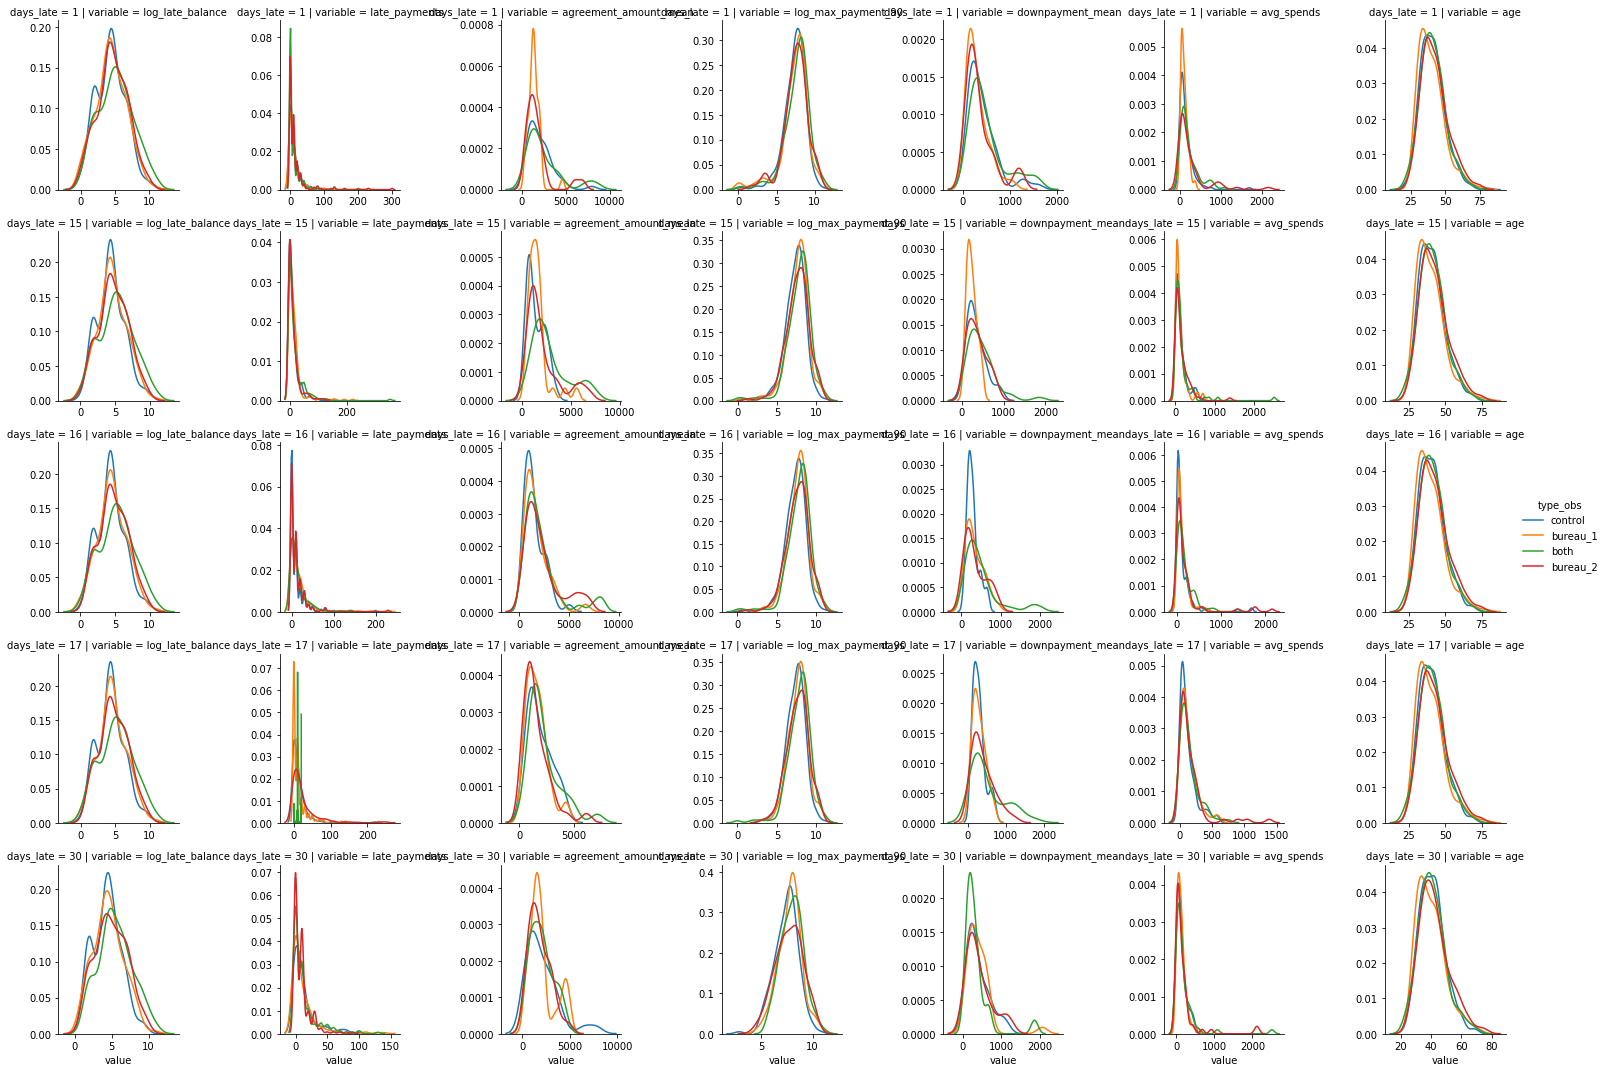

In [20]:

g1 = sns.FacetGrid(g  ,sharex=False,sharey=False,height=3
    
    
    , col='variable', hue="type_obs",row='days_late')
g1= (g1.map(sns.distplot, 'value',hist=False))
g1.add_legend()

C:\Users\Rafael\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


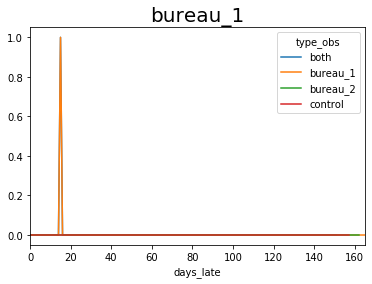

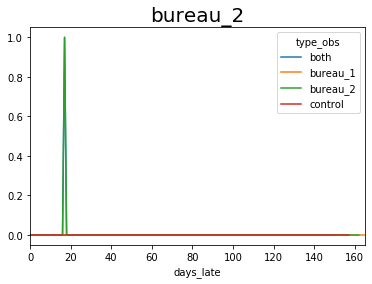

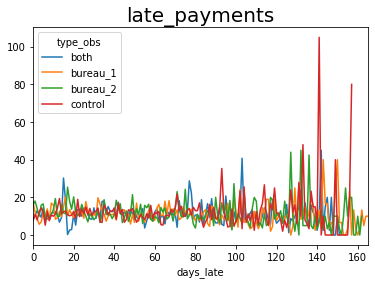

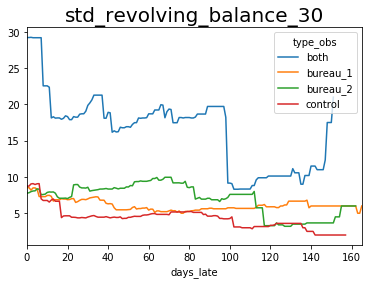

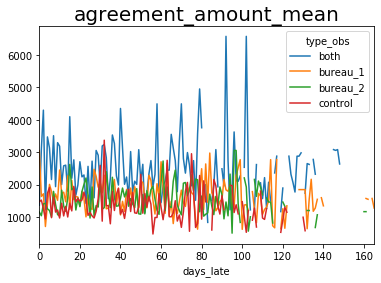

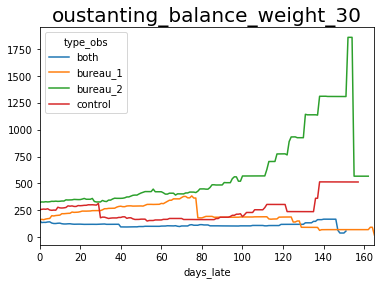

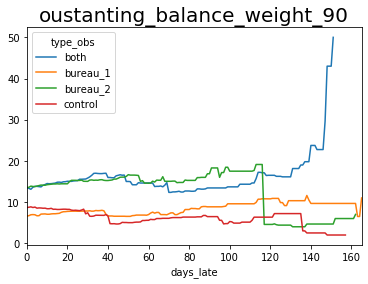

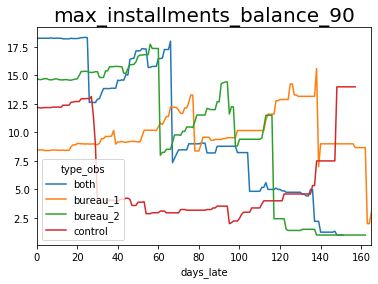

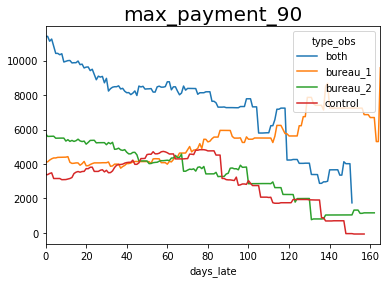

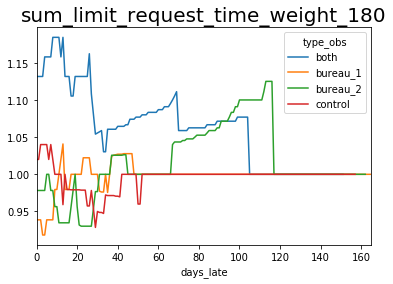

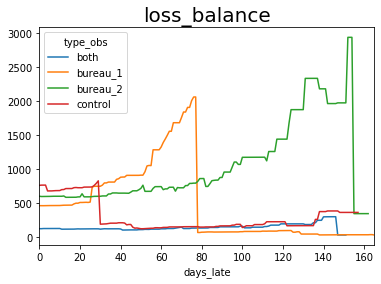

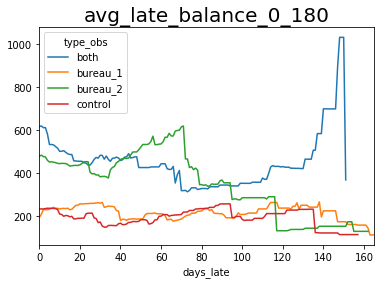

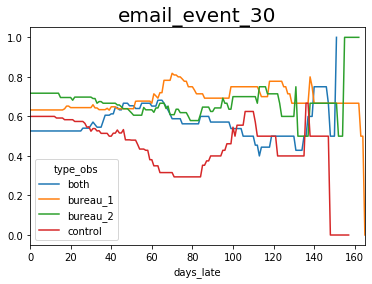

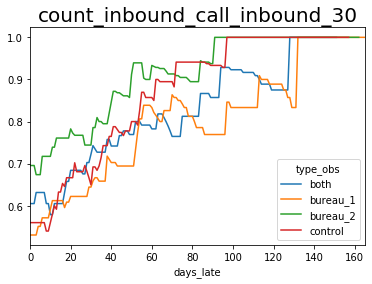

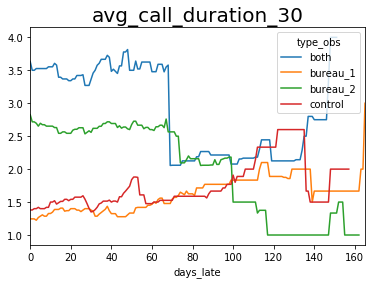

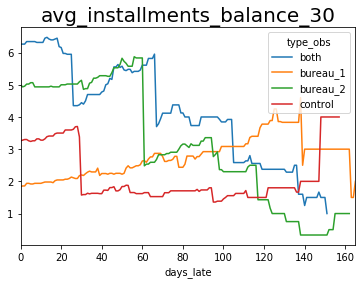

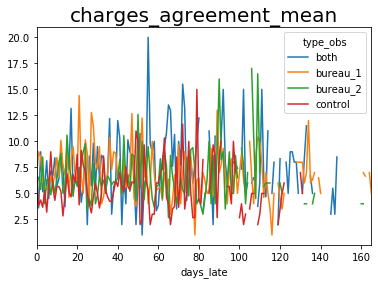

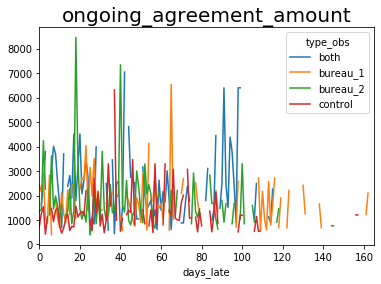

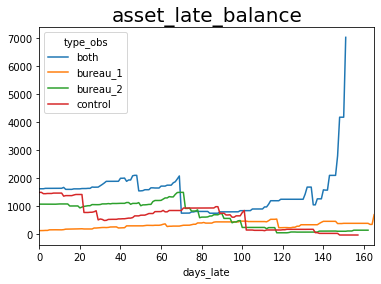

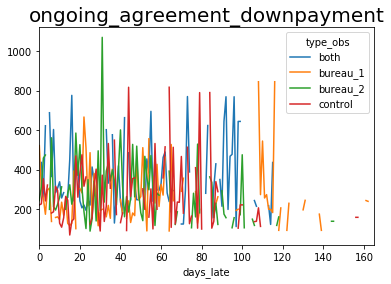

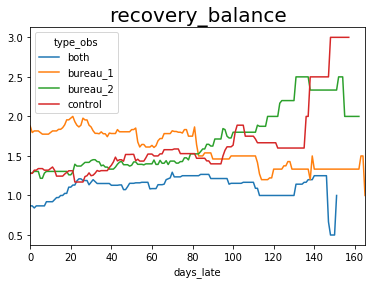

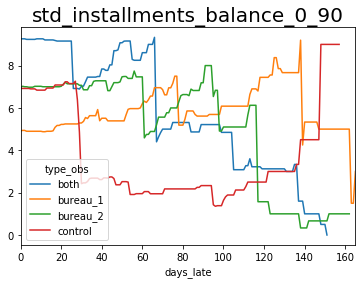

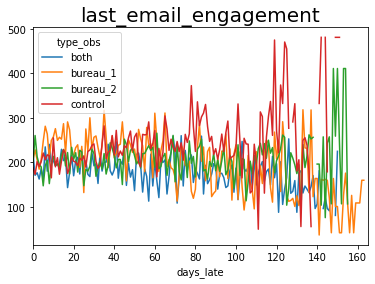

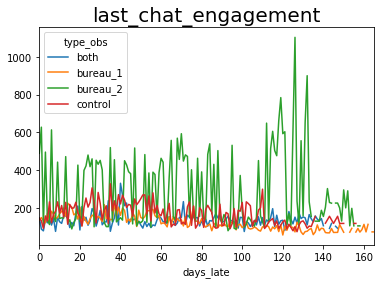

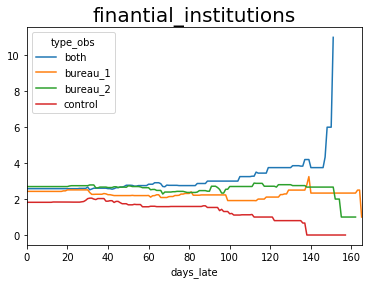

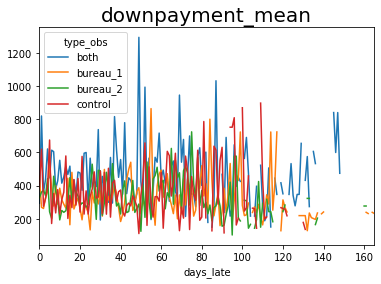

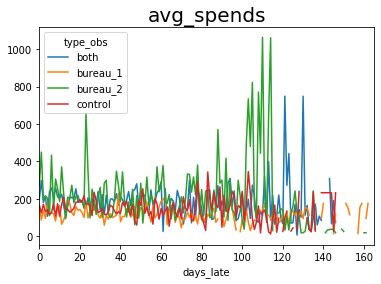

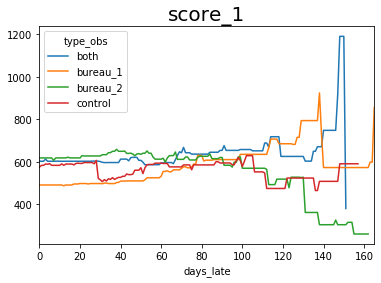

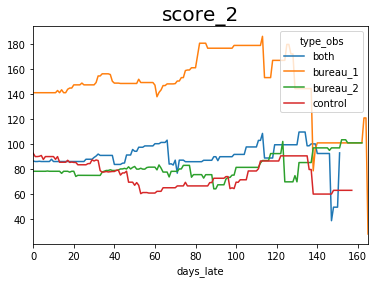

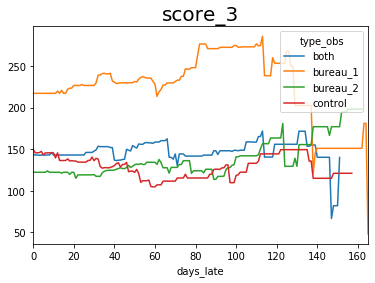

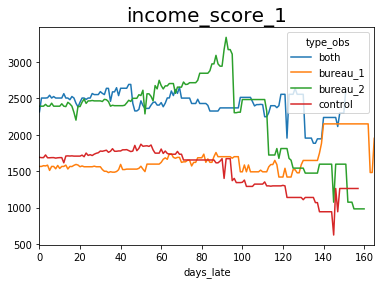

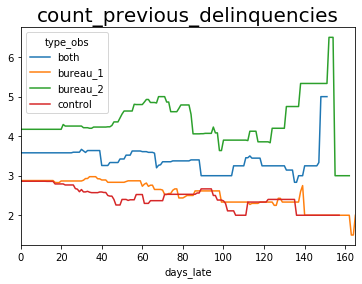

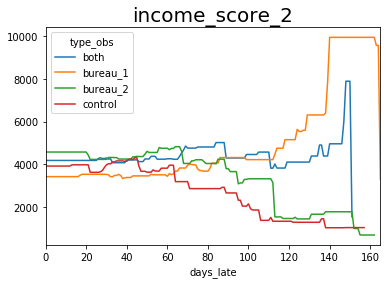

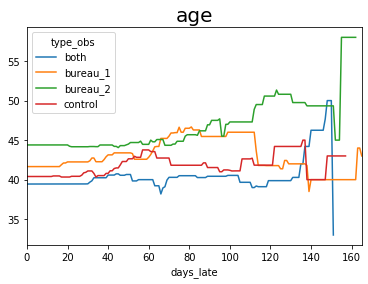

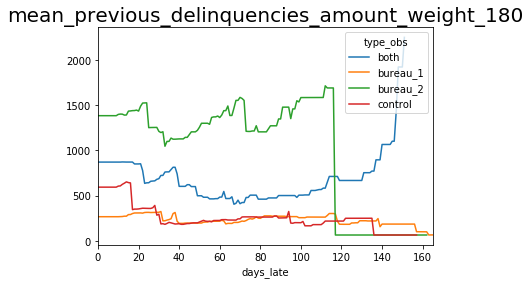

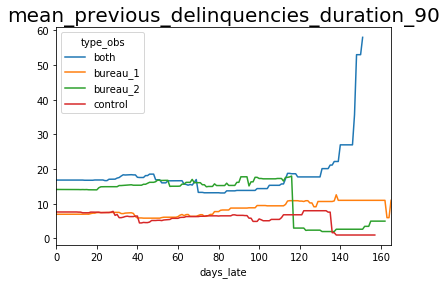

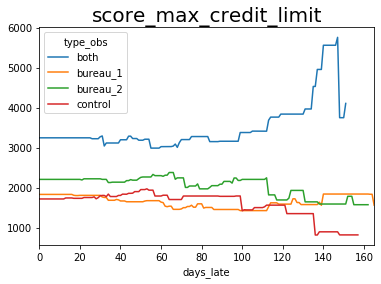

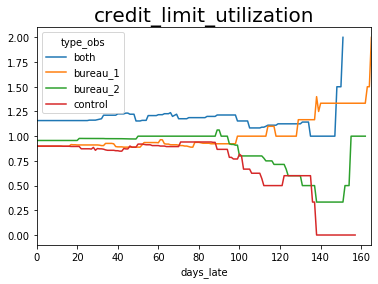

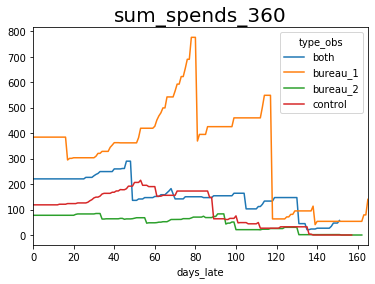

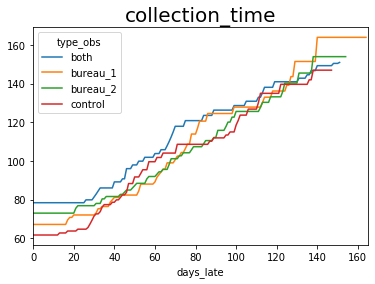

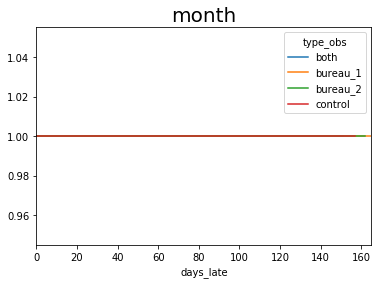

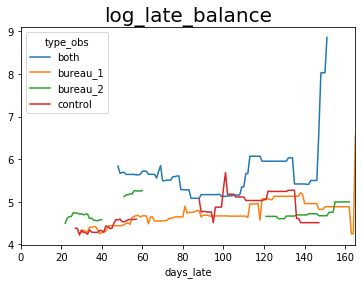

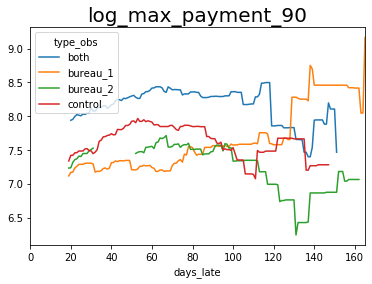

In [476]:
for i in  base.columns:
    try:
        
        avgs=groupavgs[i].plot()
        avgs.set_title(i, fontsize=20)  
        avgs.show()
    except:
        continue

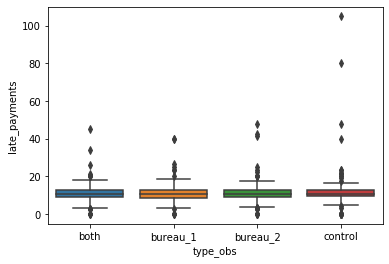

In [327]:
sns.boxplot(data=groupavgs.stack().reset_index(),y='late_payments',x='type_obs')

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot i

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

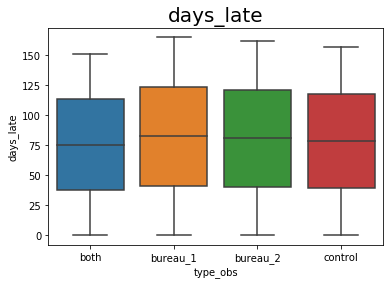

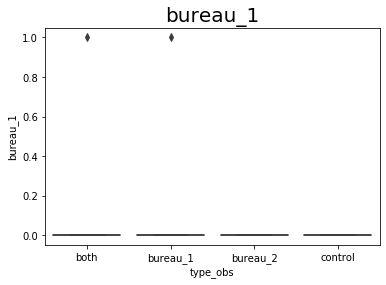

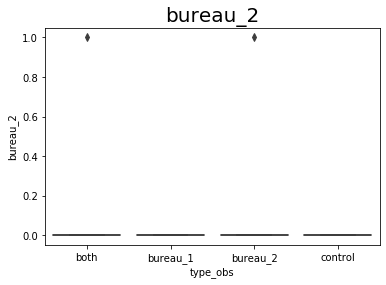

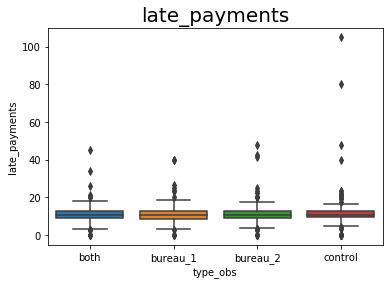

<Figure size 432x288 with 0 Axes>

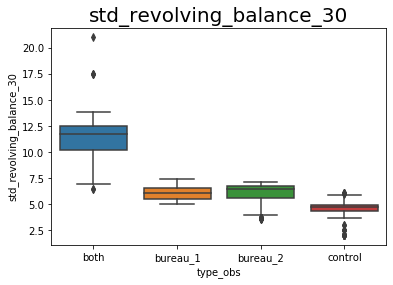

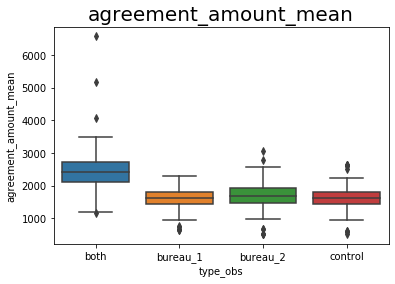

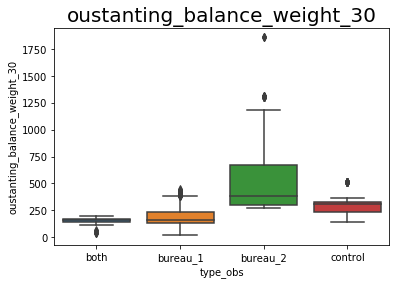

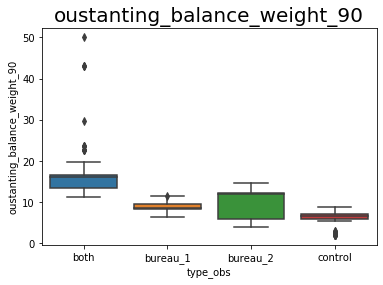

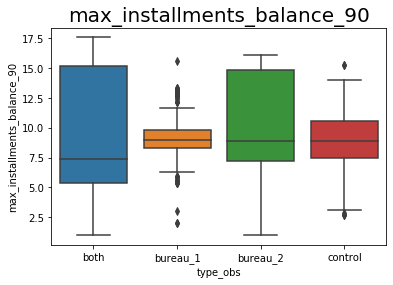

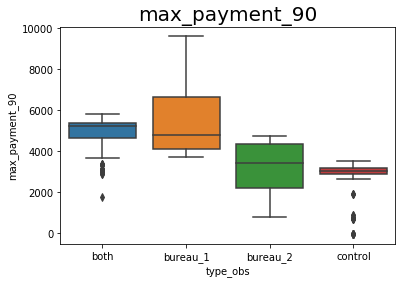

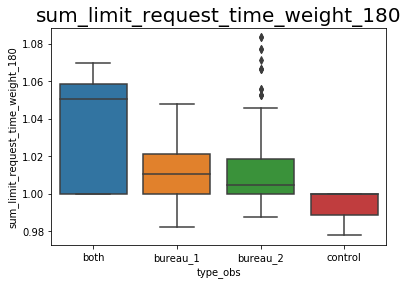

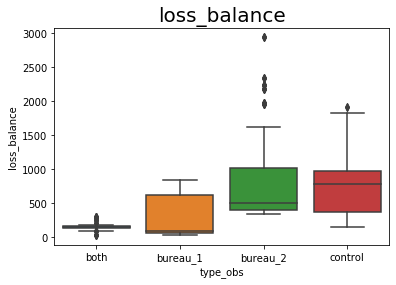

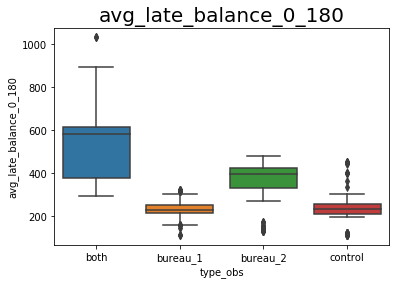

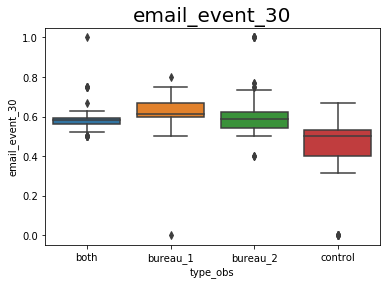

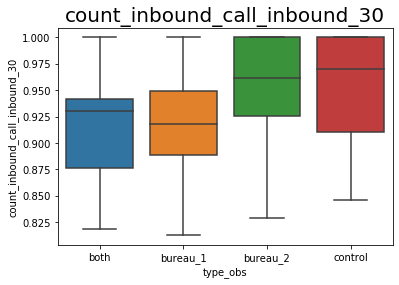

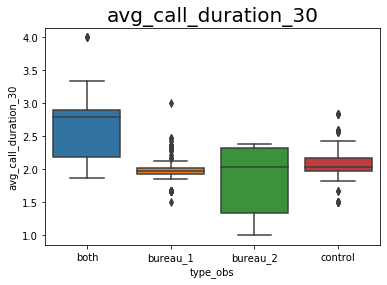

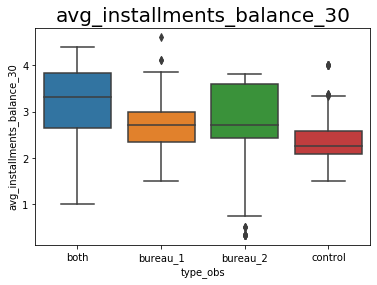

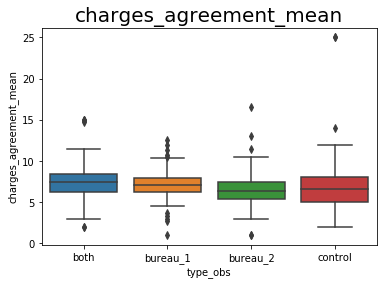

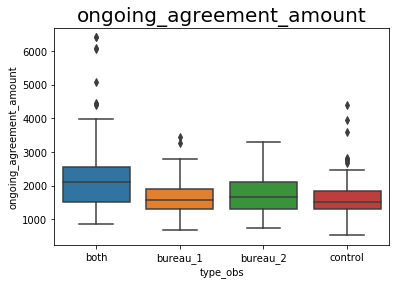

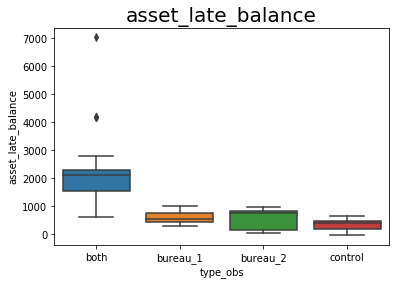

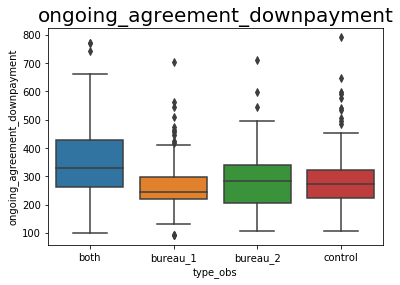

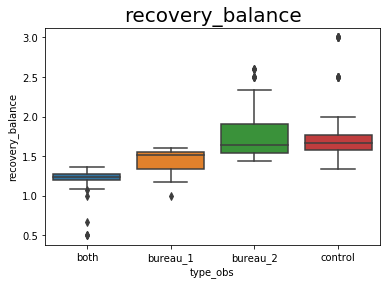

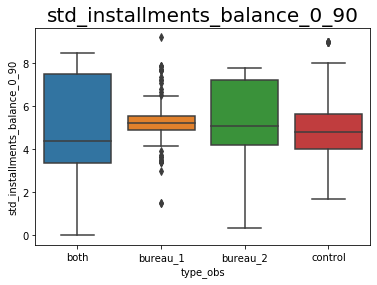

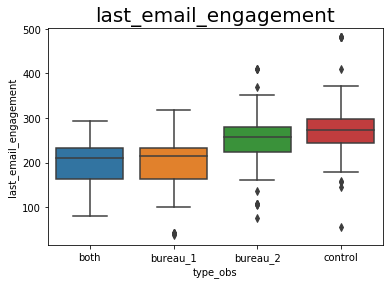

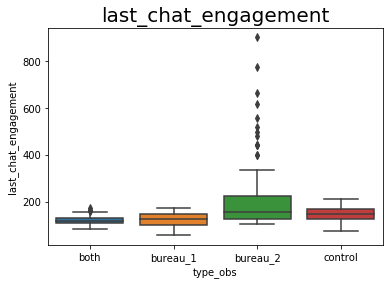

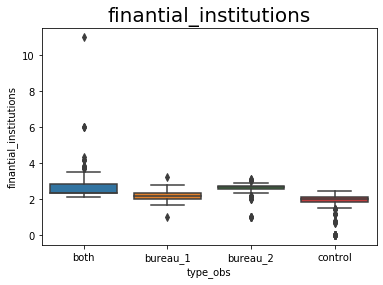

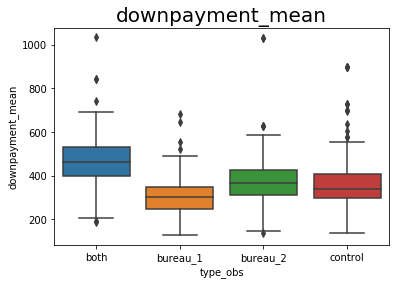

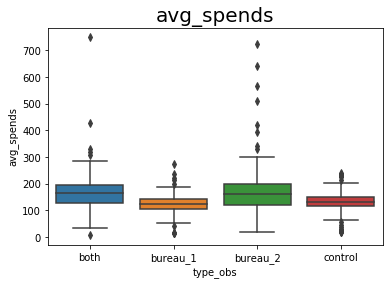

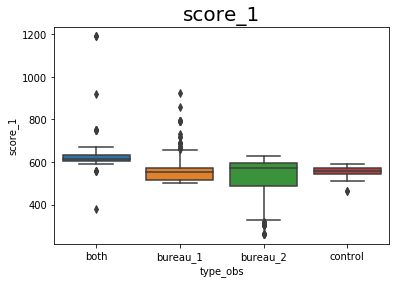

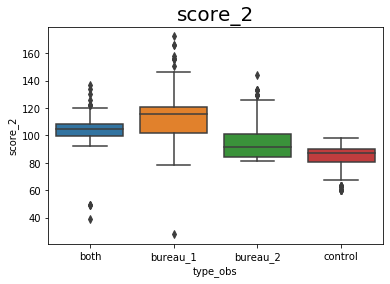

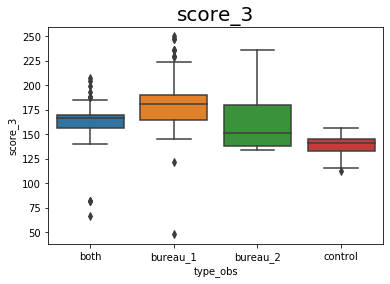

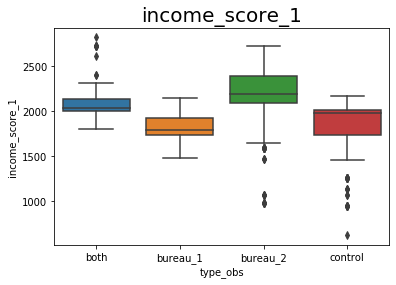

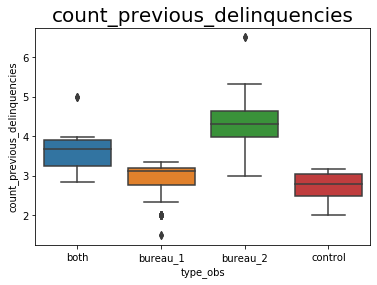

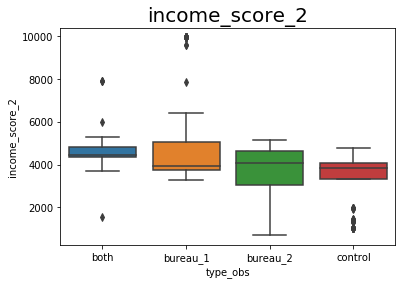

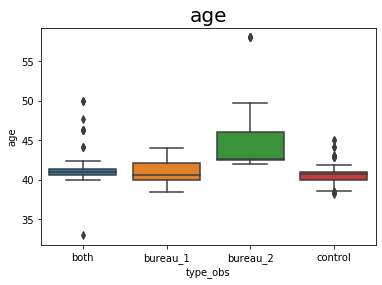

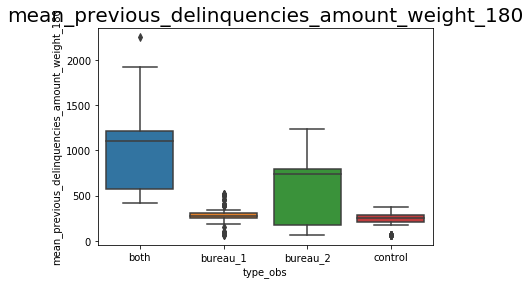

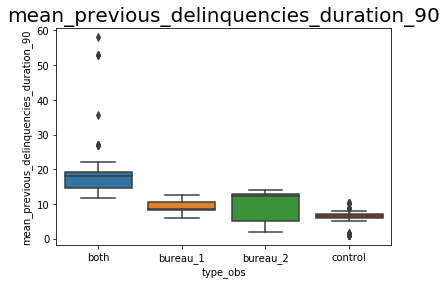

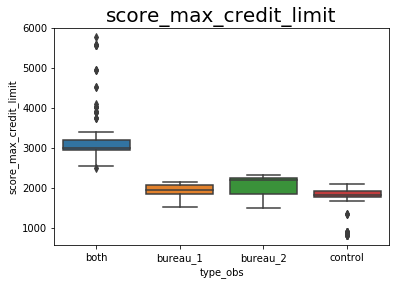

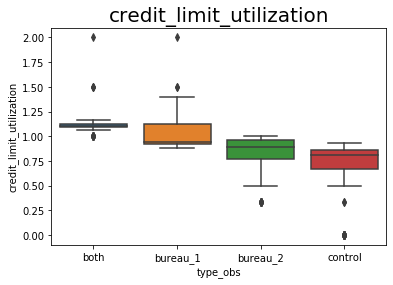

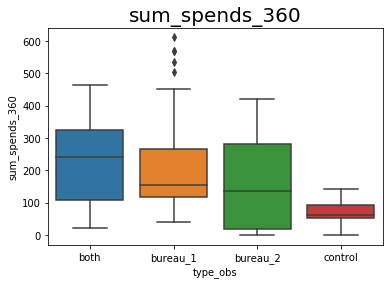

<Figure size 432x288 with 0 Axes>

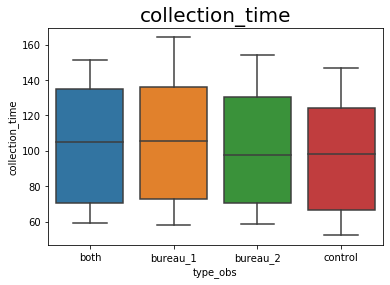

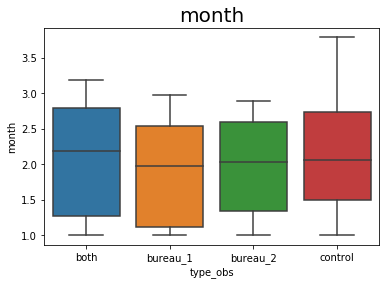

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [330]:
for i in  base.columns:
    try:
        plt.figure()
        avgs=sns.boxplot(data=groupavgs.stack().reset_index(),y=i,x='type_obs')
        
        avgs.set_title(i, fontsize=20)  
        avgs
    except:
        continue

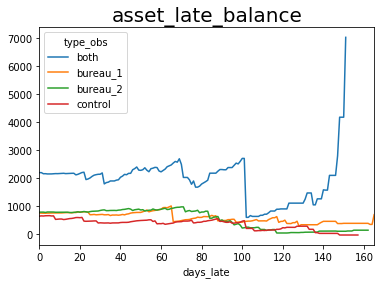

In [22]:
avgs=groupavgs['asset_late_balance'].plot()
avgs.set_title('asset_late_balance', fontsize=20)  
avgs

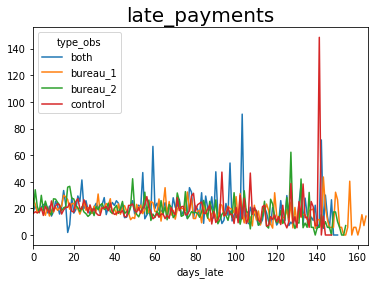

In [23]:
avgs=groupstd['late_payments'].plot()
avgs.set_title('late_payments', fontsize=20)  
avgs

In [24]:
#time=base.loc[ max_date_obs['date']].fillna(0).groupby(['type_obs','collection_time'])['id'].count()

In [25]:
time=base.loc[ max_date_obs['date']][base['month']<3]   [['type_obs','collection_time','month']].fillna(0)

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


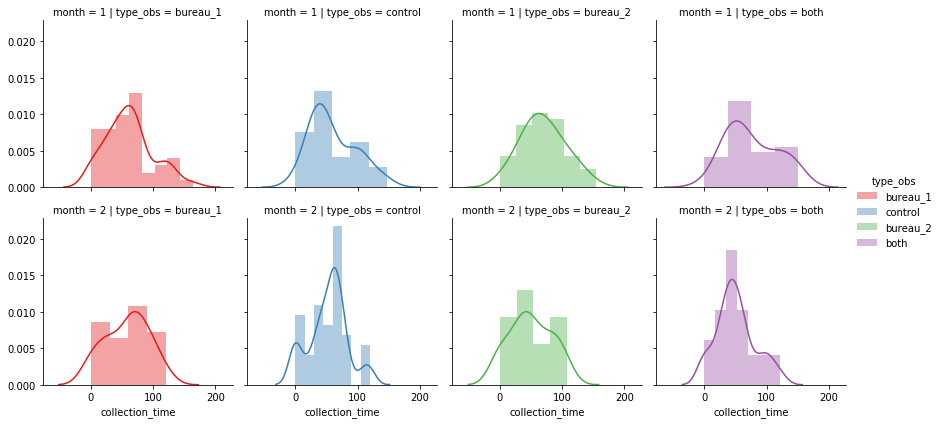

In [26]:

g = sns.FacetGrid(time,row='month', col="type_obs",hue="type_obs", palette="Set1")
g = (g.map(sns.distplot, "collection_time",hist=True))
g.add_legend()

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


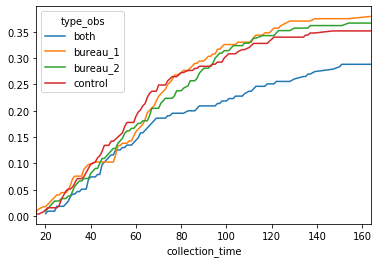

In [27]:
pars=base.loc[ max_date_obs['date']].groupby(
                                    ['type_obs'])['id'].count()
base.loc[ max_date_obs['date']  ][(pd.notna(base['collection__end'])) & (base['month']<3 ) ]  .groupby(['type_obs','collection_time'])['id'].count().unstack().T.div(pars).cumsum().fillna(method='ffill').plot()

In [28]:
max_date_obs_0=base[base['days_late']>=0].groupby('id')['date'].idxmax().reset_index()
min_date_obs_0=base[base['id'].isin(max_date_obs['id'])].groupby('id')['date'].idxmin().reset_index()

C:\Users\Rafael\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


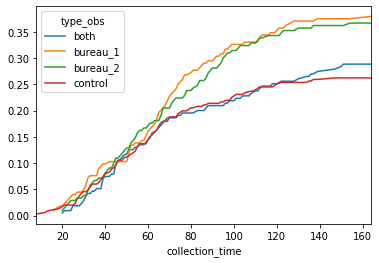

In [29]:
pars=base.loc[ max_date_obs_0['date']].fillna(0).groupby(['type_obs'])['id'].count()
base.loc[ max_date_obs_0['date']][ (pd.notna(base['collection__end']))  & (base['month']<3 ) ]  .groupby(['type_obs','collection_time'])['id'].count().unstack().T.div(pars).cumsum().fillna(method='ffill').plot()

### Hypotesis, reports to the bureaus change the probability of repayment ->logistic model with interaction effects, controls and  a fixed time windows
### Hypotesis, reports to the bureaus don't change the effort to pay monthly therefore  late_payments  per week following the intervention don't change


In [30]:
 logit_mod = sm.Logit(spector_data.endog, spector_data.exog)
logit_res = logit_mod.fit()
print(logit_res.summary())
ffair_mod = logit("affair ~ occupation + educ + occupation_husb"
                   "+ rate_marriage + age + yrs_married + children"
                   " + religious", dta).fit(
affair_mod.pred_table()
margeff = logit_res.get_margeff()
print(margeff.summary())

SyntaxError: invalid syntax (<ipython-input-30-fa07ab6d27c1>, line 8)

### There is a need to discretize time,because there is an aspect of survival analysis.Not every observation had the chance to be 90 days old

### The problem formulation is as such, given that the observations could have recieved the treatment, (where at least 17 days overdue), and given the time of the database could be observed to at least 80 days.
### In other words whats the probability that the  m1over17 observations turn into 80days late given the treatments
### I choose 80 days because there appears to be where the series diverge

In [31]:
print(base['date'].min())
print(base['date'].max())

2017-01-01 00:00:00
2017-06-15 00:00:00


In [273]:
base['date'].max()-pd.Timedelta('90days')

Timestamp('2017-03-17 00:00:00')

In [345]:
logistic_reference=base[(base['days_late']==17) & (base['collections_start']<'2017-03-17')].drop(['days_late'],axis=1)

In [381]:
logistic_reference['logistic_target']=0
logistic_reference.loc[logistic_reference['collection_time']<=90  , 'logistic_target'] = 1
logistic_reference.loc[logistic_reference['type_obs'].isin(['both','bureau_1']) ,  'bureau_1']=1

In [379]:
logistic_reference.groupby(['logistic_target','type_obs']) ['id'] .count()

logistic_target  type_obs
0                both        51
                 bureau_1    69
                 bureau_2    68
                 control     65
1                both        42
                 bureau_1    41
                 bureau_2    47
                 control     62
Name: id, dtype: int64

In [371]:
from statsmodels.formula.api import logit

In [372]:
base_discreta=pd.DataFrame()
for i in logistic_reference.select_dtypes(include='number').columns:
    try:
        base_discreta[i]=pd.qcut(logistic_reference[i].fillna(0),10,duplicates='drop')
    except: 
        continue

In [373]:
base_discreta['logistic_target']=logistic_reference['logistic_target']

In [374]:
from IPython.display import display

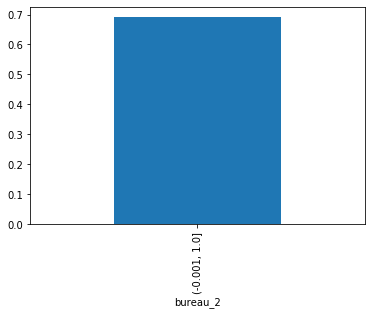

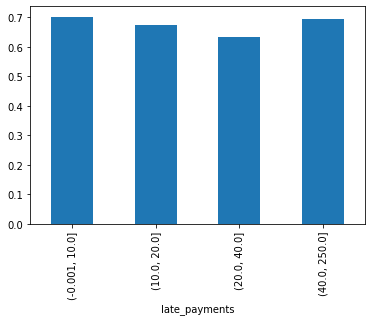

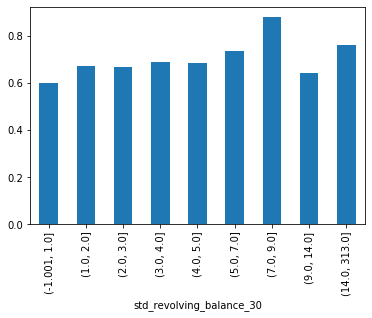

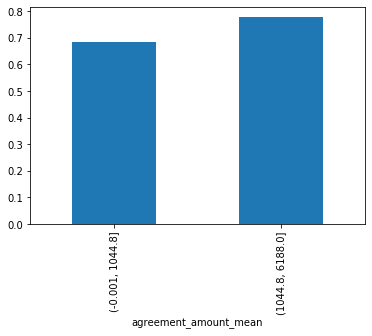

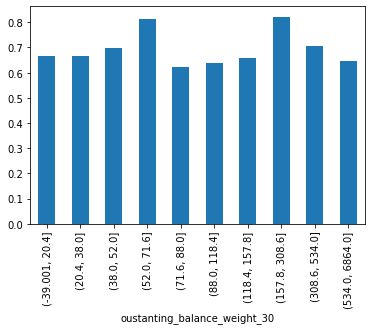

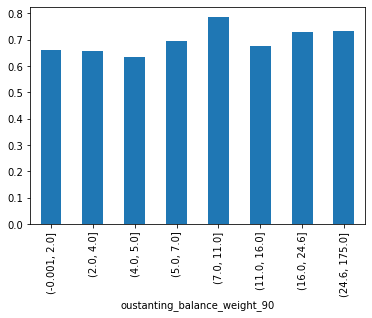

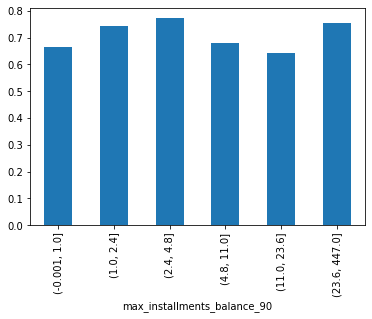

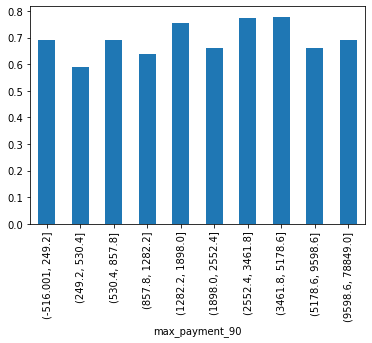

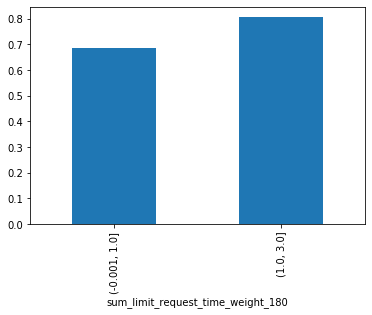

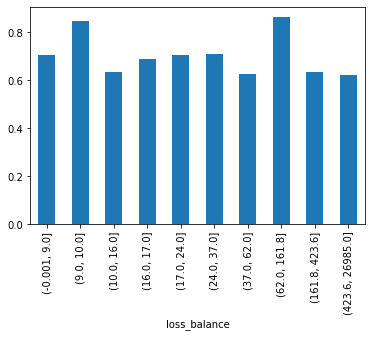

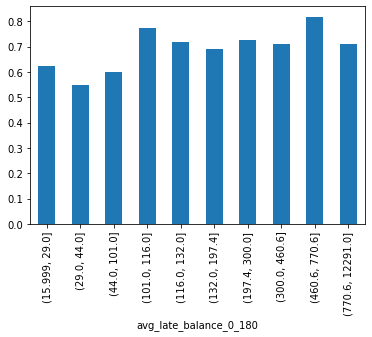

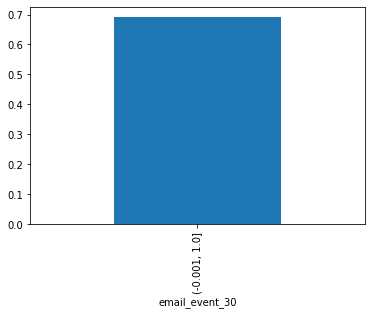

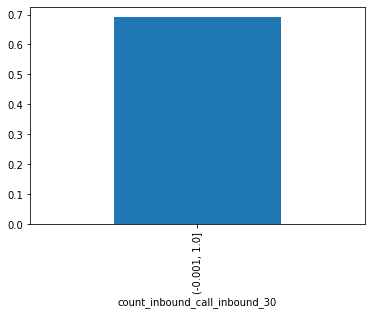

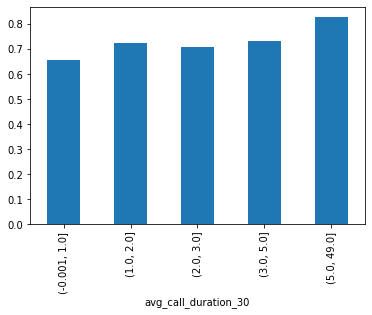

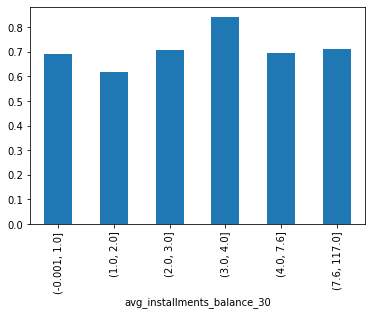

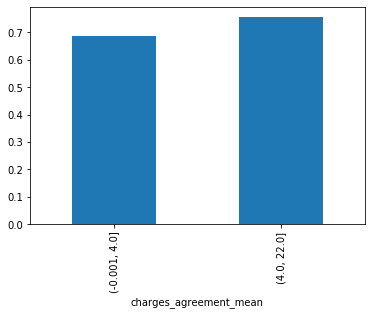

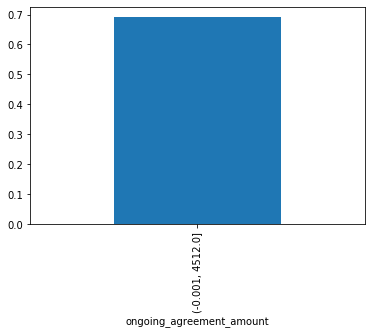

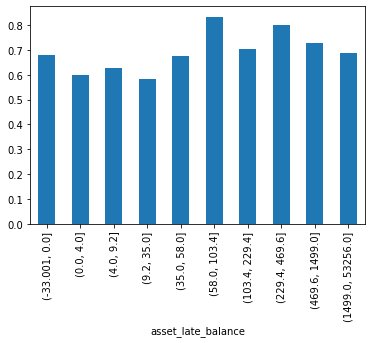

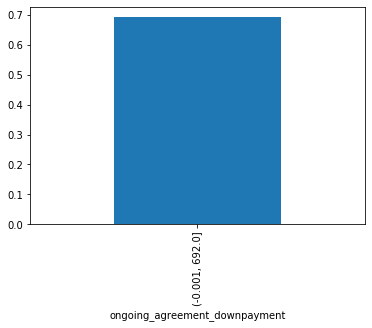

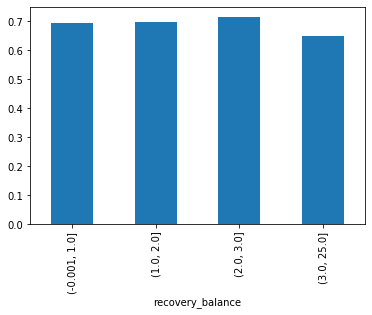

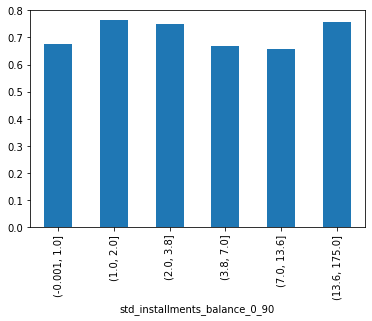

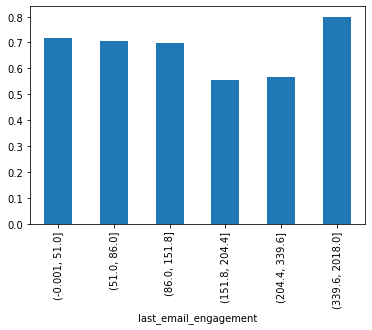

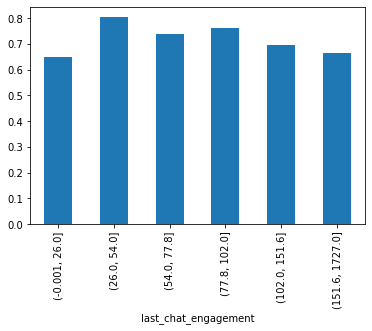

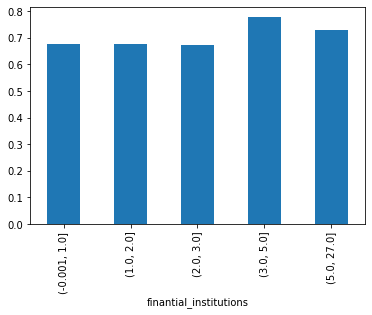

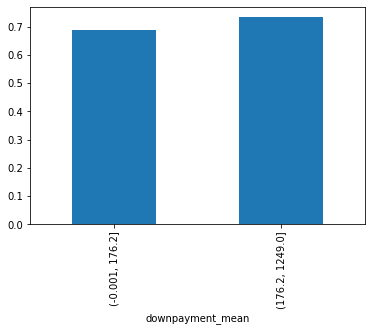

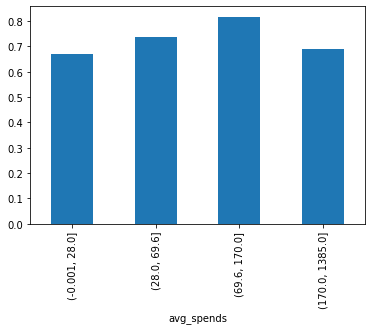

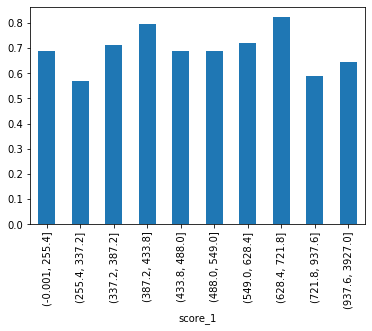

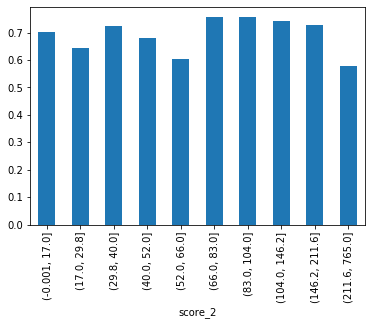

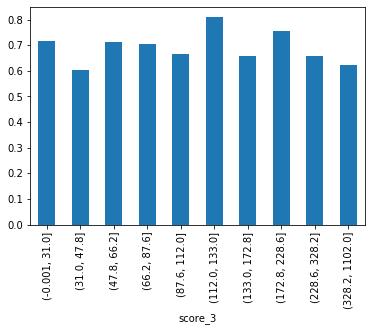

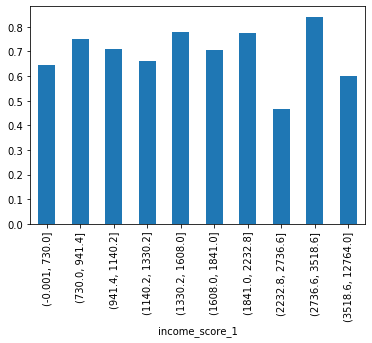

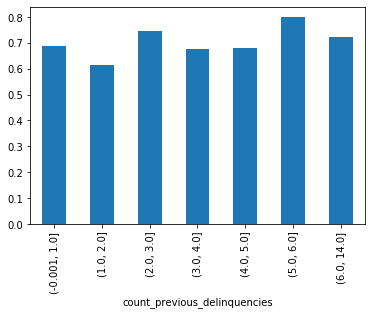

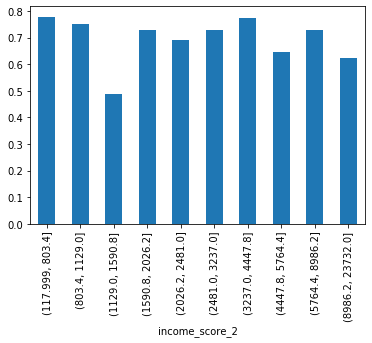

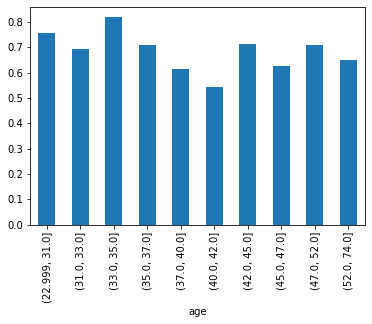

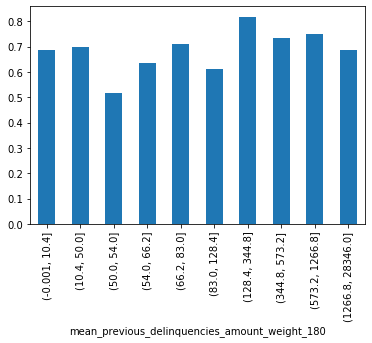

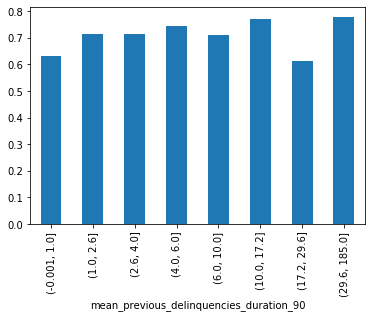

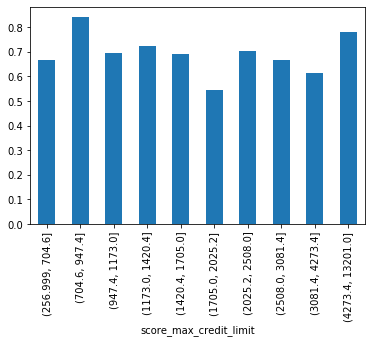

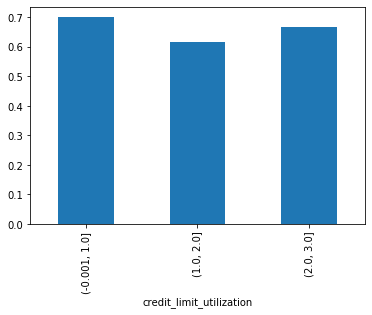

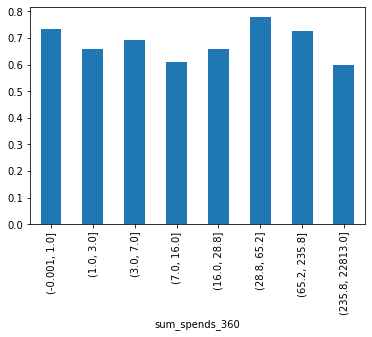

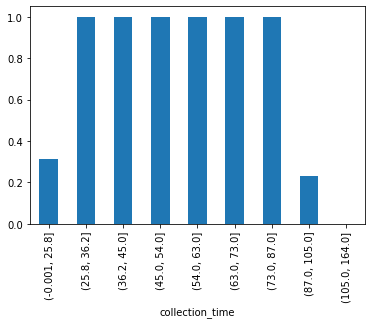

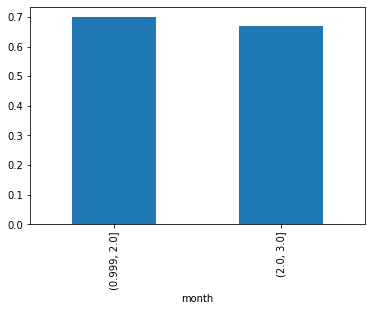

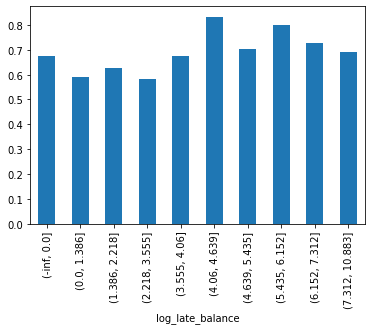

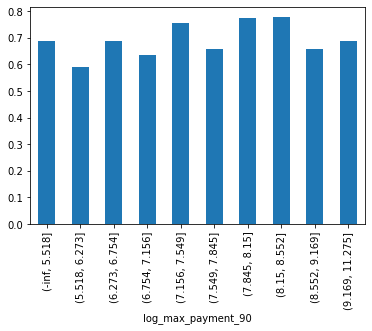

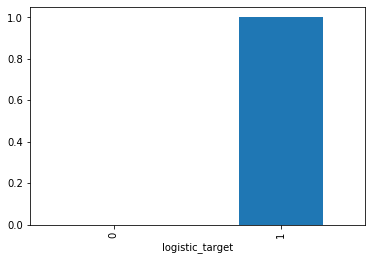

In [378]:
for i in base_discreta.columns:
    x=base_discreta.groupby( [ i,'logistic_target'])['logistic_target'].count().unstack()
    
    x.div(x.sum(axis=1),axis='index' )[1].plot(kind='bar')
    plt.show()
    

In [432]:
dic_pvalues={}
for i in  logistic_reference.columns:
    a=0
    a='logistic_target~'+i
    try:
        dic_pvalues[i]=logit(a      ,data=logistic_reference.fillna(0)).fit().pvalues[i]
    except:
        continue
    

         Current function value: 0.000000
         Iterations: 35
         Current function value: inf
         Iterations: 35
         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.616796
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616964
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617266
         Iterations 5


C:\Users\Rafael\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


         Current function value: inf
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.615794
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.614878
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616714
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616280
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.613368
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.616228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.616279
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617336
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.617301
         Iterations 5
Optimization terminat

In [433]:
series_pvalues=pd.Series(dic_pvalues).sort_values()

In [441]:
series_pvalues=series_pvalues [series_pvalues.index!='collection_time']

In [442]:
basic_model= 'logistic_target~age+bureau_1+bureau_2+bureau_1*bureau_2+'+'+'.join(series_pvalues[series_pvalues<0.25].index)

In [443]:
logit(basic_model
      ,data=logistic_reference.fillna(0)).fit().summary()

Optimization terminated successfully.
         Current function value: 0.594040
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  445
Model:                          Logit   Df Residuals:                      431
Method:                           MLE   Df Model:                           13
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                 0.03781
Time:                        22:43:31   Log-Likelihood:                -264.35
converged:                       True   LL-Null:                       -274.73
Covariance Type:            nonrobust   LLR p-value:                   0.07751
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.2822      0.557      2.302      0.021       0.190       2.374
age                                        -0.0107      0.012     -0.900      0.368      -0.034       0.013
bureau_1                                   -0.3294      0.292     -1.127      0.260      -0.902       0.244
bureau_2                                   -0.3112      0.294     -1.059      0.289      -0.887       0.265
bureau_1:bureau_2                           0.2577      0.425      0.607      0.544      -0.574       1.090
avg_call_duration_30                        0.0617      0.048      1.272      0.203      -0.033       0.157
downpayment_mean                            0.0015      0.002      1.020      0.308      -0.001       0.004
max_installments_balance_90                 0.0243      0.027      0.890      0.373      -0.029       0.078
income_score_1                             -0.0001   7.46e-05     -1.531      0.126      -0.000    3.19e-05
std_installments_balance_0_90              -0.0383      0.054     -0.707      0.480      -0.145       0.068
agreement_amount_mean                    2.381e-06      0.000      0.009      0.993      -0.001       0.001
mean_previous_delinquencies_duration_90     0.0065      0.006      1.055      0.291      -0.006       0.019
ongoing_agreement_downpayment              -0.0021      0.002     -1.268      0.205      -0.005       0.001
email_event_30                              0.2958      0.214      1.380      0.167      -0.124       0.716
===========================================================================================================
"""

In [446]:
basic_model

'logistic_target~age+bureau_1+bureau_2+bureau_1*bureau_2+avg_call_duration_30+downpayment_mean+age+max_installments_balance_90+income_score_1+std_installments_balance_0_90+agreement_amount_mean+mean_previous_delinquencies_duration_90+ongoing_agreement_downpayment+email_event_30'

In [453]:
cut_logit=logit('''logistic_target~age+bureau_1+bureau_2+avg_call_duration_30
            +age+max_installments_balance_90+income_score_1+mean_previous_delinquencies_duration_90+
            agreement_amount_mean+ongoing_agreement_downpayment+email_event_30'''
      ,data=logistic_reference.fillna(0)).fit()

Optimization terminated successfully.
         Current function value: 0.596482
         Iterations 6


In [455]:
cut_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  445
Model:                          Logit   Df Residuals:                      434
Method:                           MLE   Df Model:                           10
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                 0.03385
Time:                        22:58:42   Log-Likelihood:                -265.43
converged:                       True   LL-Null:                       -274.73
Covariance Type:            nonrobust   LLR p-value:                   0.04564
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   1.2658      0.551      2.296      0.022       0.185       2.346
age                                        -0.0117      0.012     -0.989      0.323      -0.035       0.011
bureau_1                                   -0.2118      0.212     -1.000      0.317      -0.627       0.203
bureau_2                                   -0.1884      0.217     -0.869      0.385      -0.613       0.236
avg_call_duration_30                        0.0636      0.048      1.313      0.189      -0.031       0.158
max_installments_balance_90                 0.0061      0.004      1.370      0.171      -0.003       0.015
income_score_1                             -0.0001   7.44e-05     -1.562      0.118      -0.000    2.96e-05
mean_previous_delinquencies_duration_90     0.0064      0.006      1.044      0.296      -0.006       0.018
agreement_amount_mean                       0.0002      0.000      1.396      0.163   -9.34e-05       0.001
ongoing_agreement_downpayment              -0.0021      0.002     -1.259      0.208      -0.005       0.001
email_event_30                              0.2617      0.212      1.232      0.218      -0.155       0.678
===========================================================================================================
"""

In [454]:
cut_logit.wald_test('bureau_2=0,bureau_1=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[1.697379]], p-value=0.4279754269849897, df_denom=2>

In [456]:
cut_logit.wald_test('bureau_2=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.7557431]], p-value=0.3846640020701, df_denom=1>

In [457]:
cut_logit.wald_test('bureau_1=0')

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[0.99946908]], p-value=0.3174390079701613, df_denom=1>

In [464]:
base.groupby(['asset_late_balance'])['id' ].count()

asset_late_balance
-74.0        4
-71.0       16
-64.0       14
-63.0       16
-56.0        8
            ..
 54140.0     1
 56430.0     7
 56547.0    16
 66185.0    16
 66316.0    16
Name: id, Length: 944, dtype: int64

In [463]:
base [base['id']=='7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c']

,id,date,collections_start,days_late,bureau_1,bureau_2,late_payments,collection__end,std_revolving_balance_30,agreement_amount_mean,oustanting_balance_weight_30,oustanting_balance_weight_90,max_installments_balance_90,max_payment_90,sum_limit_request_time_weight_180,loss_balance,avg_late_balance_0_180,email_event_30,count_inbound_call_inbound_30,avg_call_duration_30,avg_installments_balance_30,charges_agreement_mean,ongoing_agreement_amount,asset_late_balance,ongoing_agreement_downpayment,recovery_balance,std_installments_balance_0_90,last_email_engagement,last_chat_engagement,finantial_institutions,downpayment_mean,avg_spends,score_1,score_2,score_3,income_score_1,count_previous_delinquencies,income_score_2,age,mean_previous_delinquencies_amount_weight_180,mean_previous_delinquencies_duration_90,score_max_credit_limit,credit_limit_utilization,sum_spends_360,type_obs,collection_time,month,log_late_balance,log_max_payment_90
39447,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-15,2017-05-15,0,0,0,0,NaT,12.0,NaN,20.0,67.0,6.0,4837.0,1.0,26.0,1305.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,115.0,63.0,0.0,NaN,NaN,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.484050
39894,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-16,2017-05-15,1,0,0,0,NaT,12.0,NaN,20.0,67.0,6.0,4837.0,1.0,26.0,1303.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,NaN,63.0,0.0,NaN,40.0,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.484050
40333,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-17,2017-05-15,2,0,0,10,NaT,12.0,NaN,20.0,67.0,6.0,4837.0,1.0,26.0,1303.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,115.0,NaN,0.0,NaN,NaN,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.484050
40776,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-18,2017-05-15,3,0,0,0,NaT,12.0,NaN,20.0,67.0,6.0,4837.0,1.0,26.0,1303.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,115.0,65.0,0.0,NaN,40.0,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.484050
41222,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-19,2017-05-15,4,0,0,10,NaT,12.0,NaN,20.0,67.0,6.0,4837.0,1.0,26.0,1303.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,NaN,65.0,0.0,NaN,NaN,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.484050
41666,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-20,2017-05-15,5,0,0,10,NaT,12.0,NaN,20.0,67.0,6.0,4837.0,1.0,26.0,1303.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,NaN,65.0,0.0,NaN,40.0,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.484050
42115,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-21,2017-05-15,6,0,0,10,NaT,12.0,NaN,20.0,67.0,6.0,5083.0,1.0,26.0,1303.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,115.0,NaN,0.0,NaN,NaN,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.533657
42563,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-22,2017-05-15,7,0,0,0,NaT,12.0,NaN,20.0,67.0,6.0,5083.0,1.0,26.0,1303.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,NaN,NaN,0.0,NaN,40.0,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.533657
43012,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-23,2017-05-15,8,0,0,0,NaT,12.0,NaN,20.0,67.0,6.0,5083.0,1.0,26.0,1303.0,1.0,1.0,4.0,4.0,NaN,NaN,66316.0,NaN,0.0,4.0,NaN,65.0,0.0,NaN,NaN,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.533657
43455,7bf6a4ff-7be0-496c-9a0b-9c2b6aa7fe2c,2017-05-24,2017-05-15,9,0,0,0,NaT,12.0,NaN,20.0,67.0,6.0,5083.0,1.0,26.0,1303.0,1.0,1.0,5.0,4.0,NaN,1149.0,66316.0,412.0,0.0,4.0,NaN,NaN,0.0,NaN,NaN,1394.0,6.0,24.0,2086.0,4.0,5679.0,41.0,4260.0,177.0,1587.0,3.0,3226.0,both,NaN,5,11.102186,8.533657


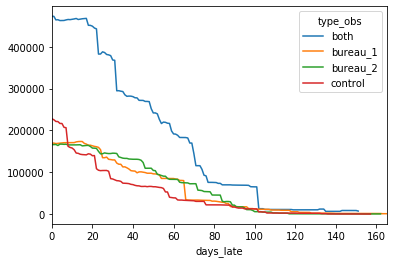

In [472]:
base.groupby(['days_late','type_obs'])['asset_late_balance'].sum().unstack().plot()

In [287]:
logit('logistic_target~age+bureau_1+bureau_2+bureau_1*bureau_2+asset_late_balance+late_payments+max_payment_90+month_1'
      ,data=logistic_reference).fit().summary()

Optimization terminated successfully.
         Current function value: 0.677114
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  445
Model:                          Logit   Df Residuals:                      436
Method:                           MLE   Df Model:                            8
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                0.009665
Time:                        18:59:31   Log-Likelihood:                -301.32
converged:                       True   LL-Null:                       -304.26
Covariance Type:            nonrobust   LLR p-value:                    0.6605
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4244      0.484      0.877      0.380      -0.524       1.373
age                   -0.0122      0.011     -1.093      0.275      -0.034       0.010
bureau_1              -0.4589      0.267     -1.720      0.085      -0.982       0.064
bureau_2              -0.2807      0.268     -1.046      0.296      -0.807       0.245
bureau_1:bureau_2      0.6508      0.405      1.607      0.108      -0.143       1.445
asset_late_balance -2.192e-05   2.32e-05     -0.946      0.344   -6.73e-05    2.35e-05
late_payments       5.593e-05      0.004      0.015      0.988      -0.007       0.007
max_payment_90     -4.061e-06    1.1e-05     -0.368      0.713   -2.57e-05    1.76e-05
month_1                0.0979      0.198      0.495      0.621      -0.290       0.485
======================================================================================
"""

In [302]:
logit('logistic_target~age+bureau_1+bureau_2+bureau_1*bureau_2+max_payment_90'
      ,data=logistic_reference).fit().summary()

Optimization terminated successfully.
         Current function value: 0.678513
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  445
Model:                          Logit   Df Residuals:                      439
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                0.007618
Time:                        19:03:07   Log-Likelihood:                -301.94
converged:                       True   LL-Null:                       -304.26
Covariance Type:            nonrobust   LLR p-value:                    0.4619
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.3772      0.471      0.802      0.423      -0.545       1.300
age                  -0.0105      0.011     -0.951      0.342      -0.032       0.011
bureau_1             -0.4587      0.266     -1.725      0.085      -0.980       0.063
bureau_2             -0.2855      0.263     -1.087      0.277      -0.800       0.229
bureau_1:bureau_2     0.6299      0.388      1.622      0.105      -0.131       1.391
max_payment_90    -3.895e-06    1.1e-05     -0.353      0.724   -2.55e-05    1.77e-05
=====================================================================================
"""

In [296]:
log_model=logit('logistic_target~age+bureau_2+bureau_1*bureau_2+income_score_1'
      ,data=logistic_reference).fit()

Optimization terminated successfully.
         Current function value: 0.675521
         Iterations 5


In [297]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:        logistic_target   No. Observations:                  439
Model:                          Logit   Df Residuals:                      433
Method:                           MLE   Df Model:                            5
Date:                Sun, 08 Mar 2020   Pseudo R-squ.:                 0.01252
Time:                        19:01:37   Log-Likelihood:                -296.55
converged:                       True   LL-Null:                       -300.31
Covariance Type:            nonrobust   LLR p-value:                    0.1846
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.6591      0.497      1.327      0.184      -0.314       1.632
age                  -0.0111      0.011     -1.000      0.317      -0.033       0.011
bureau_2             -0.3122      0.265     -1.177      0.239      -0.832       0.207
bureau_1             -0.5033      0.268     -1.876      0.061      -1.029       0.023
bureau_1:bureau_2     0.6370      0.392      1.624      0.104      -0.132       1.406
income_score_1       -0.0001   7.65e-05     -1.583      0.113      -0.000    2.88e-05
=====================================================================================
"""

In [303]:
log_model=logit('logistic_target~age+bureau_1+bureau_1*bureau_2+income_score_1'
      ,data=logistic_reference).fit()

Optimization terminated successfully.
         Current function value: 0.675521
         Iterations 5


In [245]:
from sklearn.ensemble import RandomForestClassifier

In [246]:
clf = RandomForestClassifier(max_depth=5, random_state=0,n_estimators=100)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [247]:
pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)

score_1                                          0.064180
avg_late_balance_0_180                           0.062109
score_max_credit_limit                           0.057140
avg_spends                                       0.053419
income_score_2                                   0.049263
age                                              0.048241
income_score_1                                   0.046052
asset_late_balance                               0.042088
score_3                                          0.040093
score_2                                          0.039188
mean_previous_delinquencies_amount_weight_180    0.032258
loss_balance                                     0.032252
max_payment_90                                   0.032062
std_revolving_balance_30                         0.030814
last_email_engagement                            0.030440
oustanting_balance_weight_30                     0.029966
ongoing_agreement_downpayment                    0.028684
count_previous

In [300]:
log_model.pred_table()

array([[237.,  12.],
       [175.,  15.]])

In [304]:
margeff = log_model.get_margeff()
margeff.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:        logistic_target
Method:                          dydx
At:                           overall
=====================================================================================
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.0027      0.003     -1.005      0.315      -0.008       0.003
bureau_1             -0.1215      0.064     -1.906      0.057      -0.246       0.003
bureau_2             -0.0753      0.064     -1.185      0.236      -0.200       0.049
bureau_1:bureau_2     0.1537      0.094      1.644      0.100      -0.030       0.337
income_score_1    -2.925e-05   1.83e-05     -1.601      0.109   -6.51e-05    6.57e-06
=====================================================================================
"""